<a href="https://colab.research.google.com/github/jkz22/CRIME/blob/main/CRIME_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/jkz22/CRIME.git
!cd CRIME

### **Data Loading and Preprocessing**
This section handles the initial loading of spectral data and labels, followed by essential preprocessing steps. The data is scaled using `MinMaxScaler` to normalize the feature values, which is a common practice to improve model performance. Finally, the scaled data is reshaped to be compatible with the input requirements of a 1-D Convolutional Neural Network (CNN).

In [ ]:
import torch
from sklearn.preprocessing import MinMaxScaler

# Load data and labels
data = torch.load('CRIME/example data and models/data.pt')
labels = torch.load('CRIME/example data and models/labels.pt')

# Scale data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

# Reshape data_scaled for CNN input
data_scaled_reshaped = data_scaled.reshape(data_scaled.shape[0], data_scaled.shape[1], 1)
print(f"Shape of data_scaled_reshaped: {data_scaled_reshaped.shape}")

Shape of data_scaled_reshaped: (218, 842, 1)


### **1-D CNN Model Definition**
We can start with defining our 1-D Convolutional Neural Network (CNN). For the demo, the model trained is very simple but more complex models could see different outcomes in the later stages. This part is hidden to emphasize the CRIME framework but if you want to make your own changes feel free.

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Create the 1-D CNN model
model_cnn = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(data_scaled_reshaped.shape[1], 1)),
    Conv1D(filters=64, kernel_size=3, activation='tanh', input_shape=(data_scaled_reshaped.shape[1], 1)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(units=50, activation='relu'),
    Dense(units=1)  # Output layer for regression
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [47]:
import tensorflow as tf

# Compile the model
model_cnn.compile(optimizer='adam', loss='mse')

print("Model compiled successfully.")

Model compiled successfully.


In [48]:
import tensorflow as tf

# Define the custom metric as a tf.keras.metrics.Metric subclass
class MeanRelativePercentageError(tf.keras.metrics.Metric):
    def __init__(self, name='mean_relative_percentage_error', dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.rpe_sum = self.add_weight(name='rpe_sum', initializer='zeros', dtype=tf.float32)
        self.count = self.add_weight(name='count', initializer='zeros', dtype=tf.float32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, dtype=tf.float32)
        y_pred = tf.cast(y_pred, dtype=tf.float32)

        denominator = tf.where(tf.math.equal(y_true, 0), tf.ones_like(y_true), y_true)
        rpe = tf.abs((y_pred - y_true) / denominator) * 100

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, self.dtype)
            rpe = tf.multiply(rpe, sample_weight)
            self.rpe_sum.assign_add(tf.reduce_sum(rpe))
            self.count.assign_add(tf.reduce_sum(sample_weight))
        else:
            self.rpe_sum.assign_add(tf.reduce_sum(rpe))
            self.count.assign_add(tf.cast(tf.size(rpe), dtype=tf.float32))

    def result(self):
        return self.rpe_sum / self.count

    def reset_state(self):
        self.rpe_sum.assign(0.0)
        self.count.assign(0.0)

# Recompile the model with the custom metric class instance
model_cnn.compile(optimizer='adam', loss='mse')

# Train the model with the labels cast to float32
history = model_cnn.fit(
    data_scaled_reshaped,
    tf.cast(labels.reshape(-1, 1), dtype=tf.float32), # Cast labels to float32
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

print("Model training completed.")

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - loss: 1.8041 - val_loss: 0.4855
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.5831 - val_loss: 0.5316
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.4743 - val_loss: 0.3232
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.3208 - val_loss: 0.2621
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.2796 - val_loss: 0.2196
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.2269 - val_loss: 0.2520
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.2285 - val_loss: 0.1969
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.1876 - val_loss: 0.1921
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - loss: 0.1781 - val_loss: 0.1978
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - loss: 0.1985 - val_loss: 0.2342
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.2373 - val_loss: 0.1830
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1928 - val_loss:

In [ ]:
loss, mrpe = model_cnn.evaluate(data_scaled_reshaped, tf.cast(labels.reshape(-1, 1), dtype=tf.float32), verbose=0)
print(f"Model Evaluation - Loss: {loss:.4f}")

Model Evaluation - Loss: 0.0638


In [ ]:
def model_predict(data):
    # Ensure data is reshaped for the 1-D CNN model input (num_samples, timesteps, features)
    data_reshaped_for_predict = data.reshape(data.shape[0], data.shape[1], 1)
    return model_cnn.predict(data_reshaped_for_predict)

### **Generate LIME Explanations**
This section initializes a LIME explainer and calculates individual LIME explanations for each spectrum in the dataset. LIME (Local Interpretable Model-agnostic Explanations) helps to understand the contribution of each feature (wavelength in this case) to the model's prediction for a specific instance. The data is prepared, categories are defined, and LIME explanations are computed for each spectrum.

In [ ]:
import CRIME.crime as cr
from CRIME.crime.CRIME_functions import run_CRIME
import CRIME.crime.lime_processing_functions as lpf
import pandas as pd

x_axis_values = pd.read_csv('CRIME/example data and models/xaxis.txt')[94:] # X-axis is cut to match the data.


# Initialize and run the explainer (even for classification run the mode in regression for now)
explainer = lpf.spectra_explainer(data_scaled, len(x_axis_values), 'regression')

# Categories in this instance refer to the ranges in the original data. These are primarily for the clustering plot.
categories = [data[labels == i].numpy() for i in range(4)]

# Similarly, each category label is necessary for the plot later.
category_names = ['No', 'Low', 'Medium', 'High']

# Calculate all LIME explanations for individual spectra.
lime_data, category_indicator, spectra_indicator, mean_spectra_list = lpf.calculate_lime(model_cnn, model_predict, categories, explainer, x_axis_values)


### **Perform CRIME Analysis: Encoding and Clustering**
This section performs the core CRIME analysis. It first removes the x-axis values from the LIME data, then uses a PCA (Principal Component Analysis) encoder to reduce the dimensionality of the LIME explanations. Finally, it executes the `run_CRIME` function, which performs clustering on the encoded LIME explanations to identify common patterns or 'contexts' within the data.

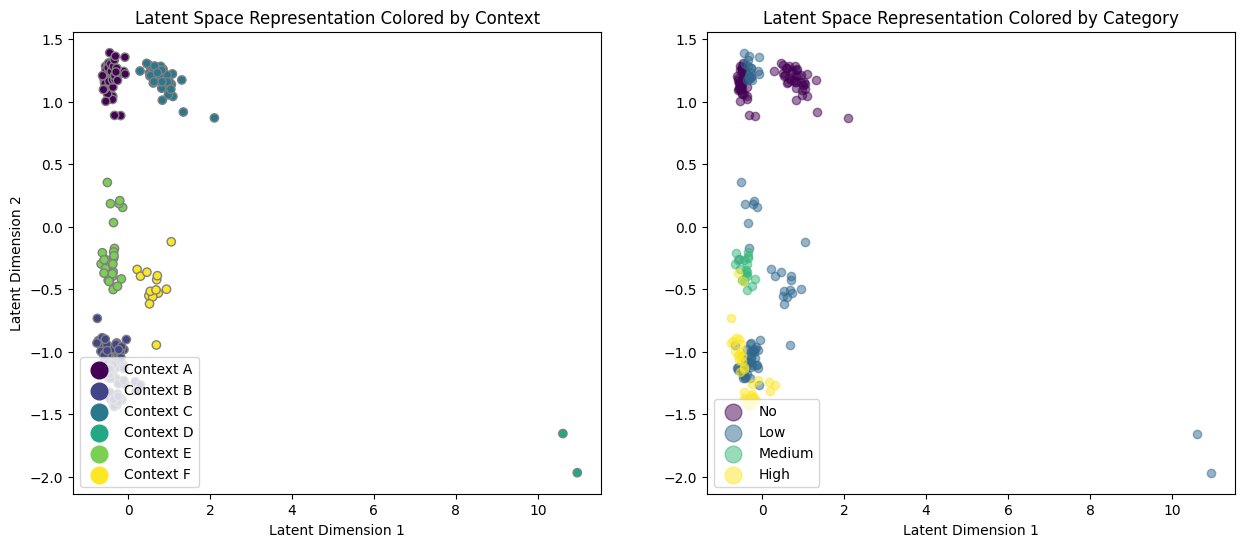

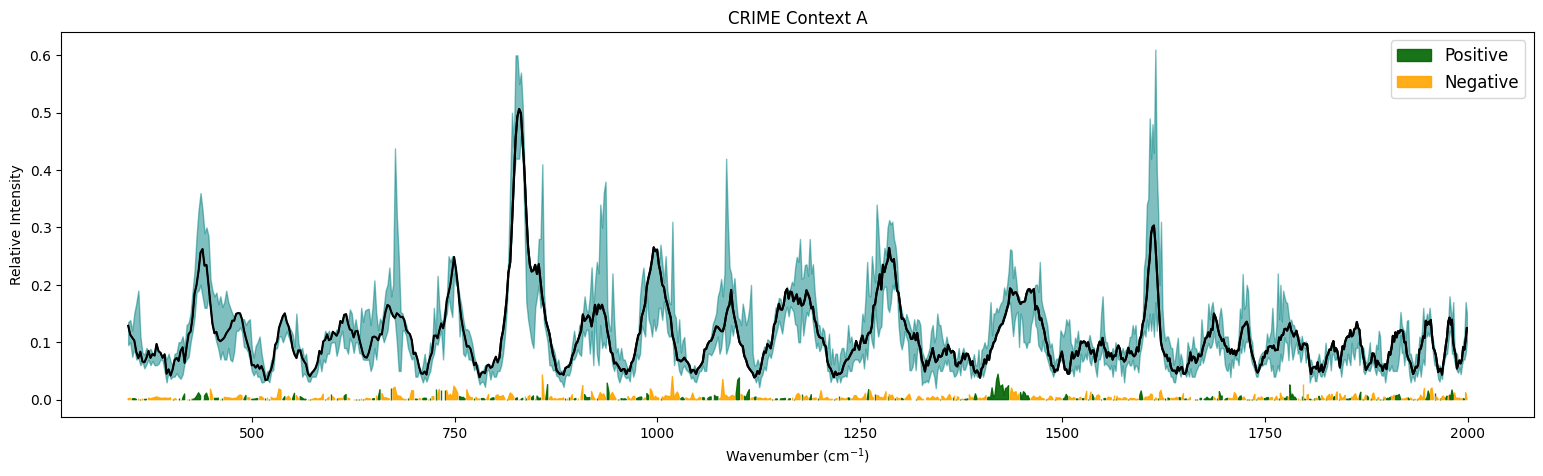

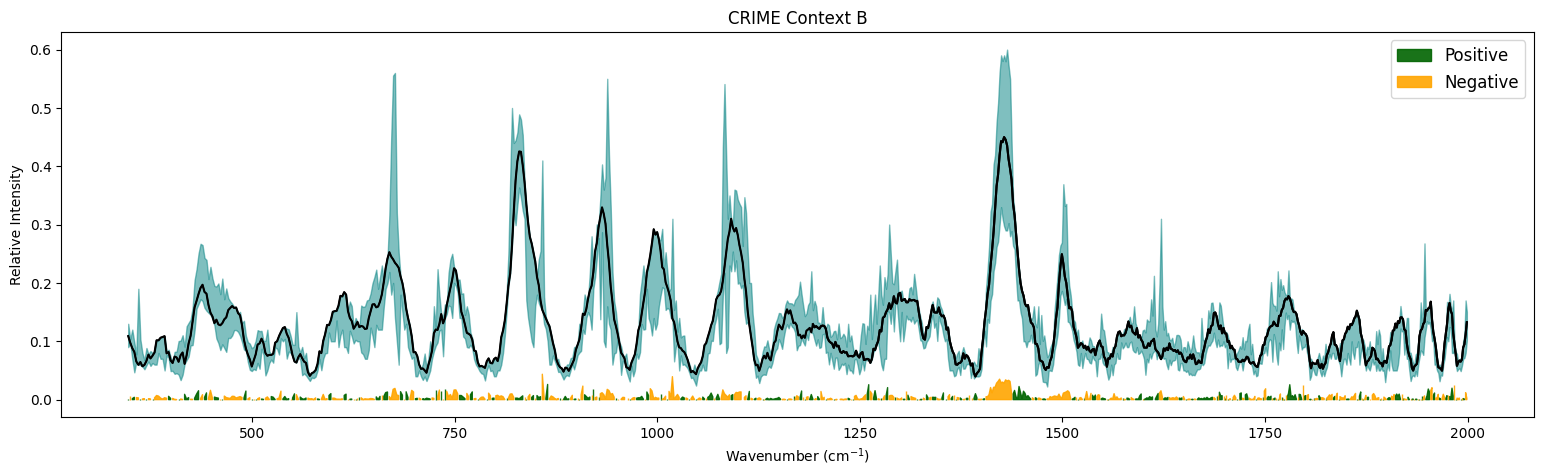

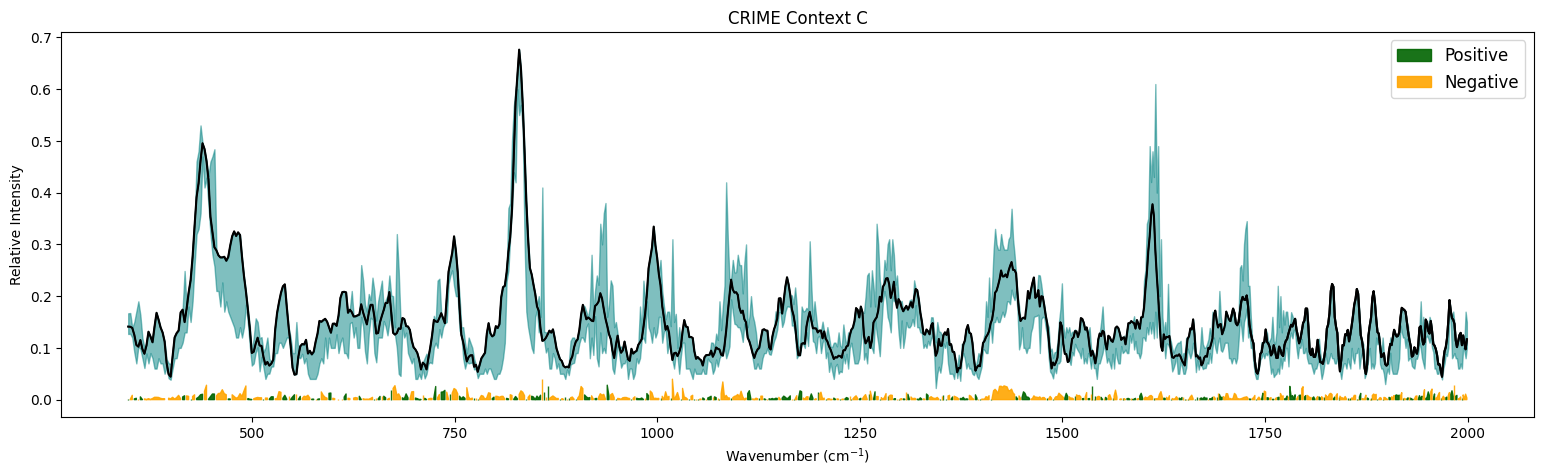

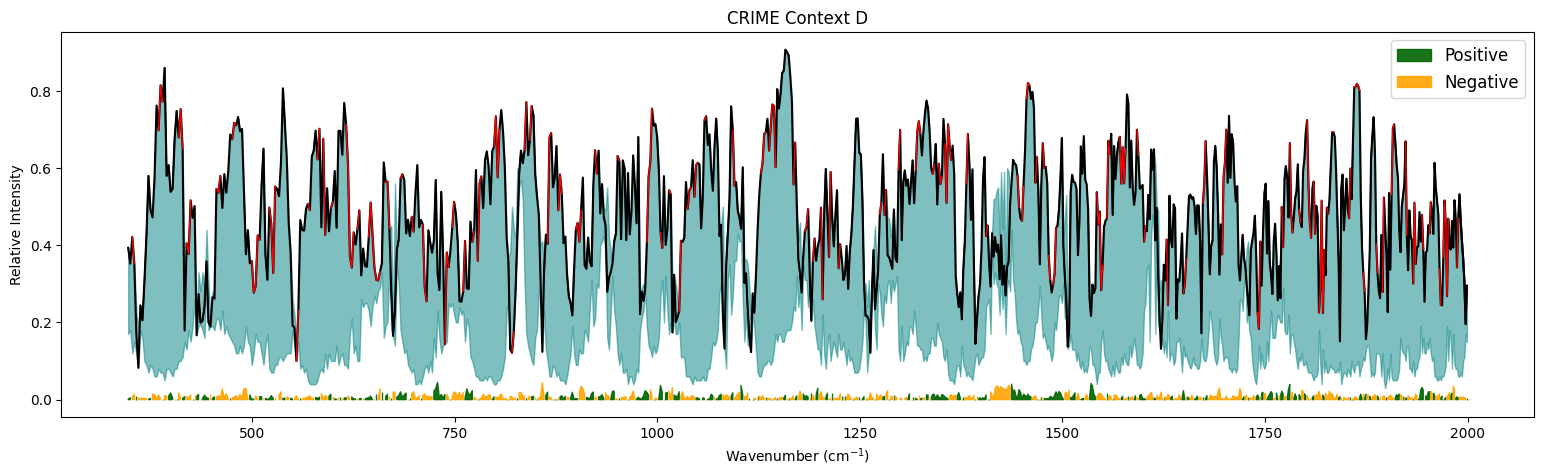

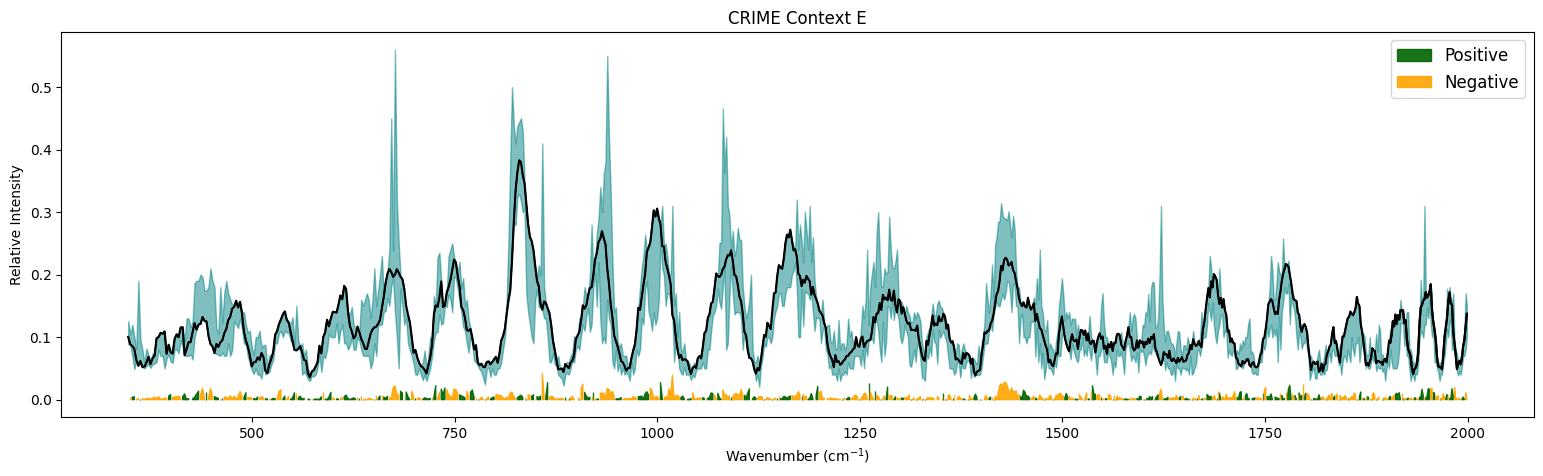

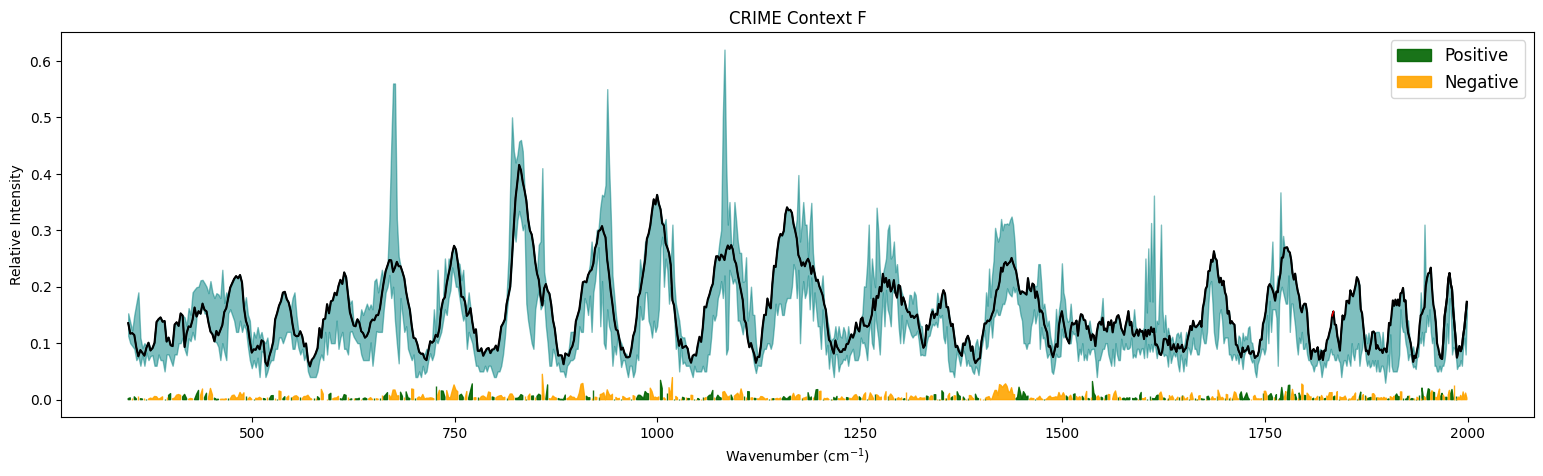

In [43]:
import CRIME.crime.CRIME_utils as utils
import numpy as np # Import numpy

'We remove the X-axis to prevent it from getting into the encoding.'
lime_data_sliced = np.array(lime_data)[:, :, 1:]

'''
Any form of encoder could be used here like a variational autoencoder but for simplicity
a PCA encoder is used
'''
# 1. Initialize and fit the encoder
encoder = utils.PCAEncoder().fit(lime_data_sliced)
'''
The number of contexts is inferred from the length of the context names variable.
Therefore it is advised that the analysis is ran once with an arbitrary amount after which the number of contexts
is selected manually.
'''
context_names = list('ABCDEF')

# Execute CRIME analysis
separated_arrays, _, spectra_means, _, _, _, top_cluster_indices_global = run_CRIME(lime_data=np.array(lime_data), encoder=encoder, cat_names=category_names, context_names=context_names, mean_spectra_list = mean_spectra_list, category_indicator = category_indicator, plot_clusters=False)

### **Similarity Matching with Target Spectra**
In this final step, the identified CRIME contexts (clustered explanations) are matched against known target spectra (e.g., serotonin, dopamine, epinephrine). This helps to associate the learned patterns from the CRIME analysis with specific, known chemical components or features. The `similarity_match` function calculates the similarity between the clustered spectra and the target spectra.

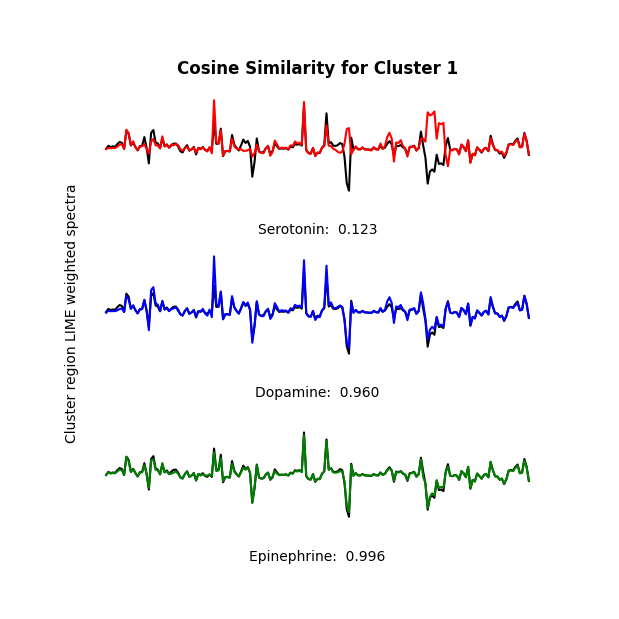

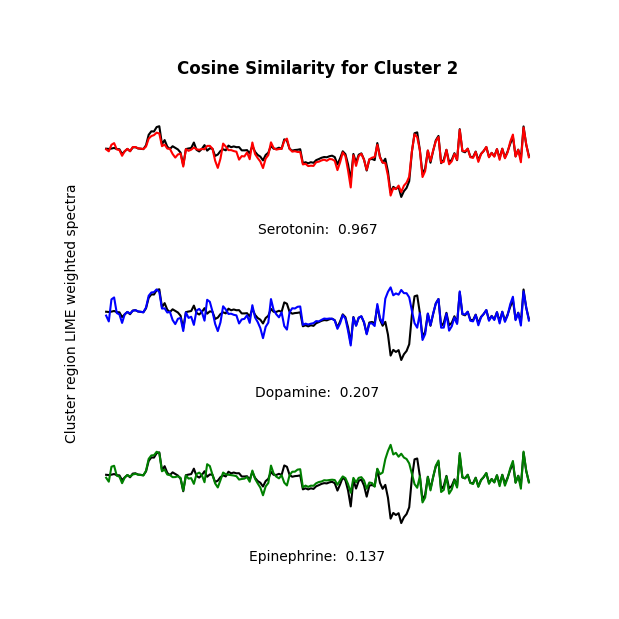

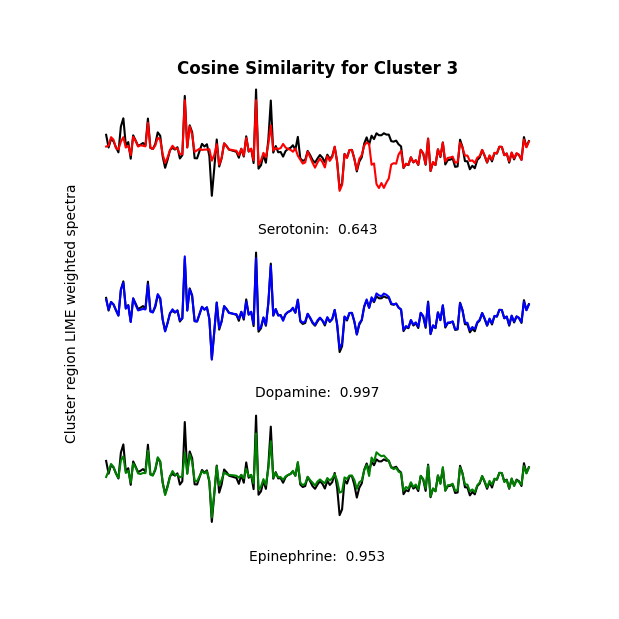

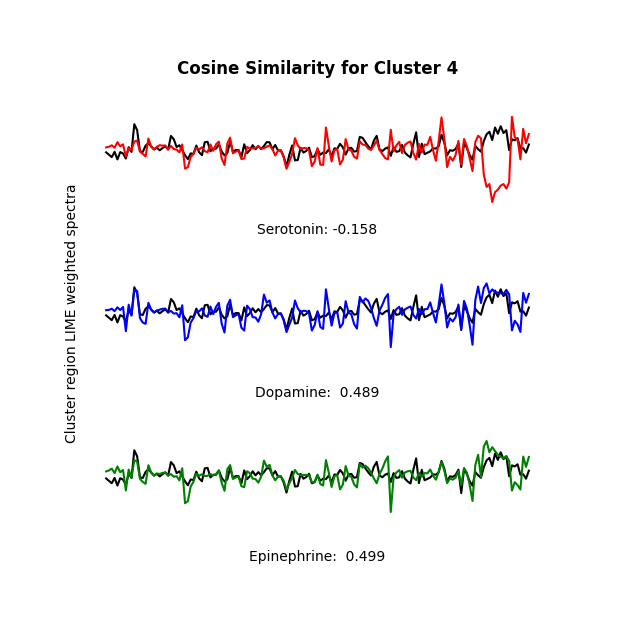

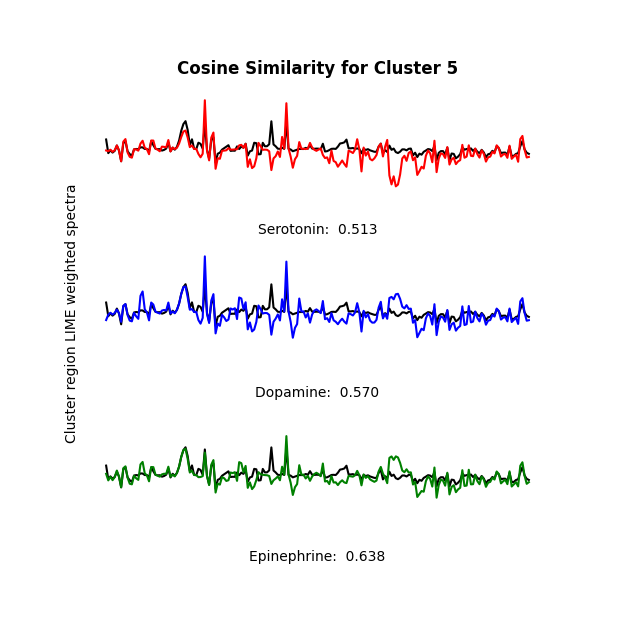

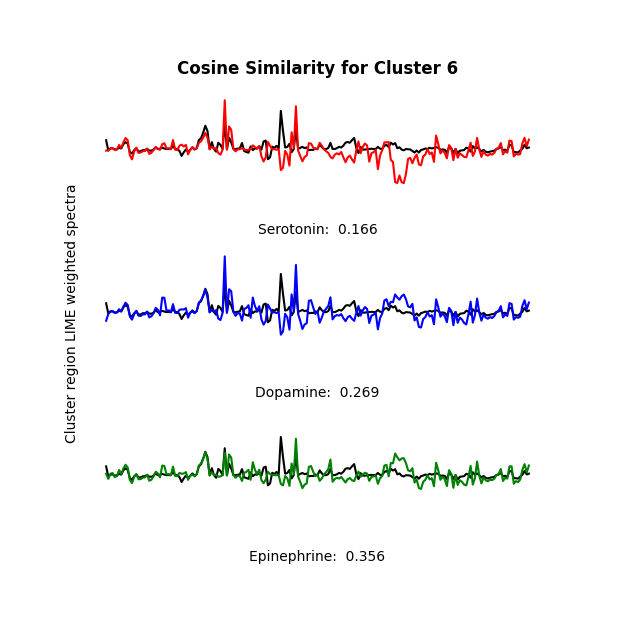

In [44]:
sero = np.load('CRIME/example data and models/serotonin.npy')
dopa = np.load('CRIME/example data and models/dopamine.npy')
epi = np.load('CRIME/example data and models/epinephrine.npy')


# Ensure colors and targets are consistent in numbers
target_spectra = [sero, dopa, epi]
target_titles = ['Serotonin', 'Dopamine', 'Epinephrine']
target_colors = ['red', 'blue', 'green']

matched_targets, combined_similarities = cr.similarity_match(target_spectra, target_titles, target_colors, separated_arrays, top_cluster_indices_global, spectra_means)
